Library imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

import utilities as utils

Loads the datacube

In [2]:
data = utils.load_dataset("data/LAWLEY22-DATACUBE/2021_Table04_Datacube.csv")
data.head()

,"ï»¿""H3_Address""",H3_Resolution,H3_Geometry,Longitude_EPSG4326,Latitude_EPSG4326,Continent_Majority,Continent_Minority,Country_Majority,Country_Minority,Province_Majority,...,Litmod_Density_Asthenosphere,Litmod_Density_Crust,Litmod_Density_Lithosphere,Crust1_Type,Crust1_CrustalThickness,Crust1_SedimentThickness,Training_MVT_Deposit,Training_MVT_Occurrence,Training_CD_Deposit,Training_CD_Occurrence
0,8712e579bffffff,7,"POLYGON ((-115.0314 54.5077, -115.0393 54.4961...",-115.018142,54.497221,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260254,3337.300049,island arc,-38.450497,2991.459961,Absent,Absent,Absent,Absent
1,8712e579affffff,7,"POLYGON ((-115.0658 54.51706, -115.0737 54.505...",-115.052542,54.506590,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300293,island arc,-38.430000,3000.000244,Absent,Absent,Absent,Absent
2,8712e56b4ffffff,7,"POLYGON ((-115.0604 54.49501, -115.0682 54.483...",-115.047107,54.484541,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.259766,3337.300049,island arc,-38.430000,3000.000000,Absent,Absent,Absent,Absent
3,8712e56b5ffffff,7,"POLYGON ((-115.026 54.48564, -115.0338 54.4740...",-115.012729,54.475169,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-38.591599,2932.666504,Absent,Absent,Absent,Absent
4,8712e56a6ffffff,7,"POLYGON ((-114.997 54.49832, -115.0049 54.4867...",-114.983753,54.487840,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-39.815273,2422.801758,Absent,Absent,Absent,Absent


In [3]:
# modifies presence / absence columns to boolean - geology properties
data["Geology_Dictionary_Alkalic"] = data["Geology_Dictionary_Alkalic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Anatectic"] = data["Geology_Dictionary_Anatectic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Calcareous"] = data["Geology_Dictionary_Calcareous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Carbonaceous"] = data["Geology_Dictionary_Carbonaceous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Cherty"] = data["Geology_Dictionary_Cherty"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_CoarseClastic"] = data["Geology_Dictionary_CoarseClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Evaporitic"] = data["Geology_Dictionary_Evaporitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Felsic"] = data["Geology_Dictionary_Felsic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_FineClastic"] = data["Geology_Dictionary_FineClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Gneissose"] = data["Geology_Dictionary_Gneissose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Igneous"] = data["Geology_Dictionary_Igneous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Intermediate"] = data["Geology_Dictionary_Intermediate"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Pegmatitic"] = data["Geology_Dictionary_Pegmatitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_RedBed"] = data["Geology_Dictionary_RedBed"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Schistose"] = data["Geology_Dictionary_Schistose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Sedimentary"] = data["Geology_Dictionary_Sedimentary"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_UltramaficMafic"] = data["Geology_Dictionary_UltramaficMafic"].apply(lambda x: True if x == "Present" else False)
# modifies presence / absence columns to boolean - labels
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

Selects the data /labels used for MVT WOE baseline

In [4]:
cols_dict = utils.load_features_dict(deptype='MVT', baseline='preferred')
data_filtered, cols = utils.extract_cols(data, cols_dict)

# converts the categorical variables to one-hot encoded vectors for ML compatibility
# data_filtered = pd.get_dummies(data_filtered, columns=['Geology_Lithology_Majority','Geology_Lithology_Minority','Geology_Period_Maximum_Majority','Geology_Period_Minimum_Majority'], prefix=['Geology_Lithology_Majority','Geology_Lithology_Minority','Geology_Period_Maximum_Majority','Geology_Period_Minimum_Majority'])

data_filtered.info()

data_filtered_aus = data_filtered[data_filtered["Continent_Majority"] == "Oceania"]
data_filtered_uscan = data_filtered[data_filtered["Continent_Majority"] == "North America"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 29 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   H3_Geometry                                     object 
 1   Continent_Majority                              object 
 2   Latitude_EPSG4326                               float64
 3   Geology_Lithology_Majority                      object 
 4   Geology_Lithology_Minority                      object 
 5   Geology_Period_Maximum_Majority                 object 
 6   Geology_Period_Minimum_Majority                 object 
 7   Sedimentary_Dictionary                          bool   
 8   Igneous_Dictionary                              bool   
 9   Metamorphic_Dictionary                          bool   
 10  Seismic_LAB_Priestley                           float64
 11  Seismic_Moho                                    float64
 12  Gravity_GOCE_ShapeIndex     

The following function finds all the neighbors and creates a new column "MVT_Deposit".
Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). 

In [5]:
data_filtered_aus = utils.neighbor_deposits(data_filtered_aus, deptype='MVT')
data_filtered_uscan = utils.neighbor_deposits(data_filtered_uscan, deptype='MVT')

/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{deptype}_Deposit'] = df.apply(lambda row: True if True in [row[f'Training_{deptype}_Deposit'], row[f'Training_{deptype}_Occurrence']] else False, axis=1)
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H3_Geometry2'] = df['H3_Geometry'].apply(lambda x: x[10:-2].split(', ')[:-1])
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:

In [6]:
print(data_filtered_aus['Training_MVT_Deposit'].value_counts())
print(data_filtered_uscan['Training_MVT_Deposit'].value_counts())

Training_MVT_Deposit
False    1544765
True          46
Name: count, dtype: int64
Training_MVT_Deposit
False    3619855
True         167
Name: count, dtype: int64


In [7]:
labels_filtered_aus = data_filtered_aus['MVT_Deposit']
dep_filtered_aus = data_filtered_aus['Training_MVT_Deposit']
geometry_filtered_aus = data_filtered_aus["H3_Geometry"]
continent_filtered_aus = data_filtered_aus["Continent_Majority"]
lats_filtered_aus = data_filtered_aus["Latitude_EPSG4326"]

labels_filtered_uscan = data_filtered_uscan['MVT_Deposit']
dep_filtered_uscan = data_filtered_uscan['Training_MVT_Deposit']
geometry_filtered_uscan = data_filtered_uscan["H3_Geometry"]
continent_filtered_uscan = data_filtered_uscan["Continent_Majority"]
lats_filtered_uscan = data_filtered_uscan["Latitude_EPSG4326"]

data_filtered_aus = data_filtered_aus.drop(columns=['H3_Geometry', 'Continent_Majority', 'Latitude_EPSG4326', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
data_filtered_uscan = data_filtered_uscan.drop(columns=['H3_Geometry', 'Continent_Majority', 'Latitude_EPSG4326', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])


cols = cols[3:-2]

Clearly the dataset has MANY outliers, as reported in the paper

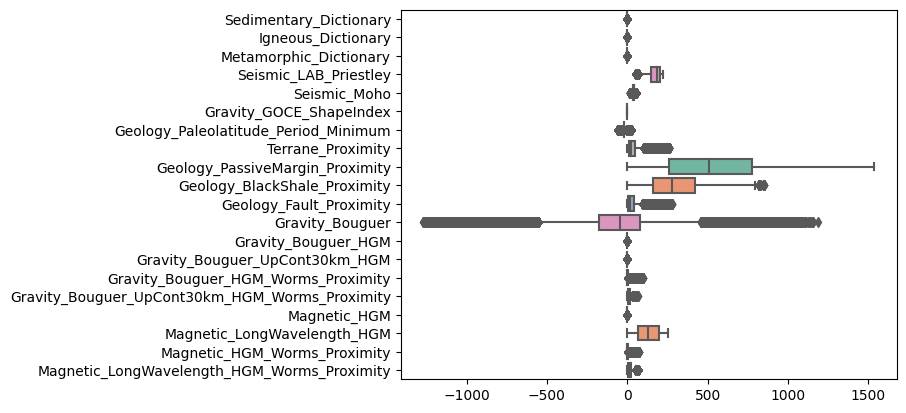

In [8]:
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

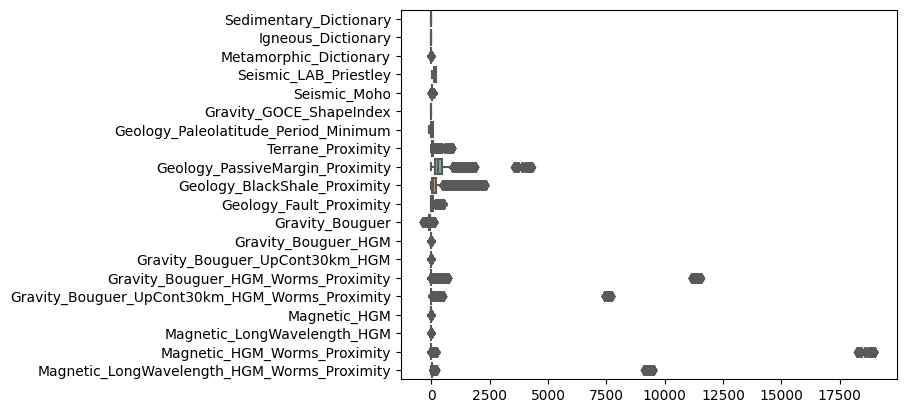

In [9]:
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

We can remove these outliers

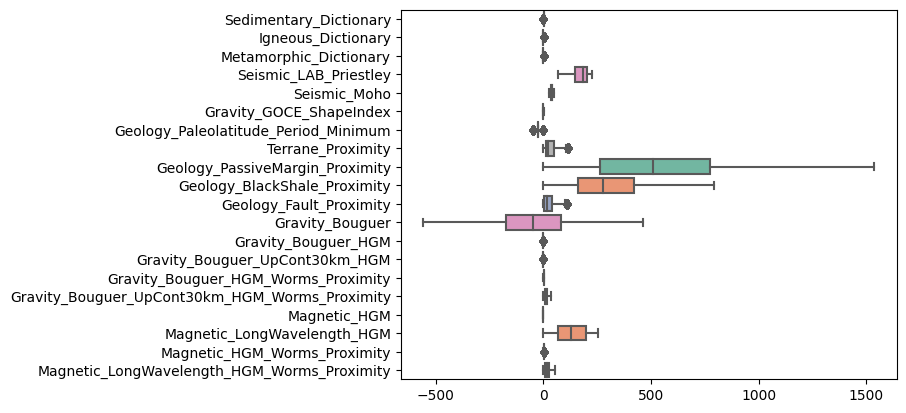

In [10]:
data_filtered_aus = utils.tukey_remove_outliers(data_filtered_aus)
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

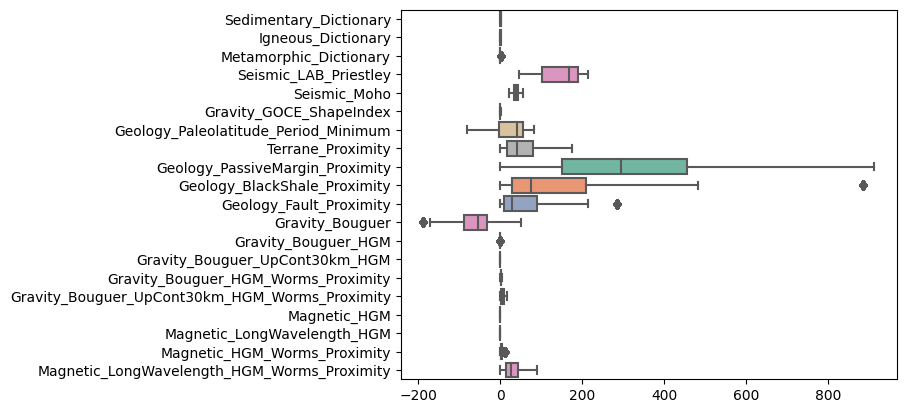

In [11]:
data_filtered_uscan = utils.tukey_remove_outliers(data_filtered_uscan)
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [12]:
print(data_filtered_aus.isna().sum())

Geology_Lithology_Majority                             0
Geology_Lithology_Minority                             0
Geology_Period_Maximum_Majority                        0
Geology_Period_Minimum_Majority                        0
Sedimentary_Dictionary                                 0
Igneous_Dictionary                                     0
Metamorphic_Dictionary                                 0
Seismic_LAB_Priestley                                  0
Seismic_Moho                                           0
Gravity_GOCE_ShapeIndex                                0
Geology_Paleolatitude_Period_Minimum              154947
Terrane_Proximity                                      0
Geology_PassiveMargin_Proximity                        0
Geology_BlackShale_Proximity                           0
Geology_Fault_Proximity                                0
Gravity_Bouguer                                        0
Gravity_Bouguer_HGM                                    0
Gravity_Bouguer_UpCont30km_HGM 

In [13]:
print(data_filtered_uscan.isna().sum())

Geology_Lithology_Majority                             0
Geology_Lithology_Minority                           410
Geology_Period_Maximum_Majority                    44289
Geology_Period_Minimum_Majority                    44289
Sedimentary_Dictionary                                 0
Igneous_Dictionary                                     0
Metamorphic_Dictionary                                 0
Seismic_LAB_Priestley                                  0
Seismic_Moho                                        1266
Gravity_GOCE_ShapeIndex                                0
Geology_Paleolatitude_Period_Minimum              884529
Terrane_Proximity                                      0
Geology_PassiveMargin_Proximity                        0
Geology_BlackShale_Proximity                           0
Geology_Fault_Proximity                                0
Gravity_Bouguer                                    36359
Gravity_Bouguer_HGM                                36403
Gravity_Bouguer_UpCont30km_HGM 

In [14]:
data_filtered_aus = utils.impute_nans(data_filtered_aus)
print(data_filtered_aus.isna().sum())

Geology_Lithology_Majority                        0
Geology_Lithology_Minority                        0
Geology_Period_Maximum_Majority                   0
Geology_Period_Minimum_Majority                   0
Sedimentary_Dictionary                            0
Igneous_Dictionary                                0
Metamorphic_Dictionary                            0
Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Geology_Paleolatitude_Period_Minimum              0
Terrane_Proximity                                 0
Geology_PassiveMargin_Proximity                   0
Geology_BlackShale_Proximity                      0
Geology_Fault_Proximity                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Boug

In [15]:
data_filtered_uscan = utils.impute_nans(data_filtered_uscan)
print(data_filtered_uscan.isna().sum())

Geology_Lithology_Majority                        0
Geology_Lithology_Minority                        0
Geology_Period_Maximum_Majority                   0
Geology_Period_Minimum_Majority                   0
Sedimentary_Dictionary                            0
Igneous_Dictionary                                0
Metamorphic_Dictionary                            0
Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Geology_Paleolatitude_Period_Minimum              0
Terrane_Proximity                                 0
Geology_PassiveMargin_Proximity                   0
Geology_BlackShale_Proximity                      0
Geology_Fault_Proximity                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Boug

Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


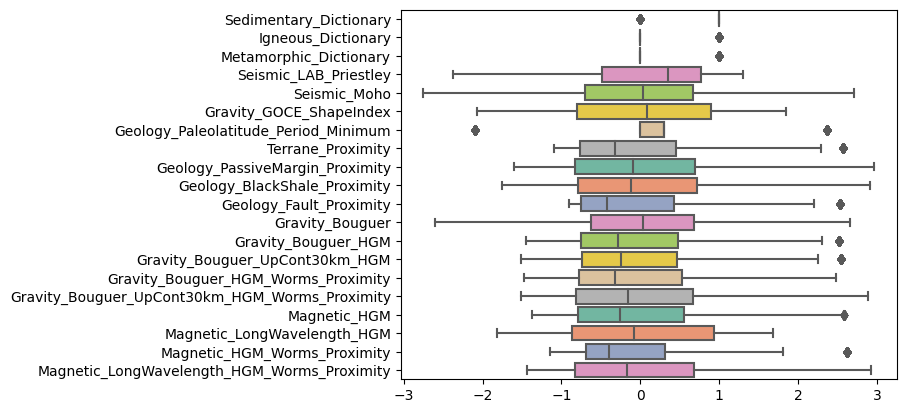

In [16]:
data_filtered_aus = utils.normalize_df(data_filtered_aus)
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


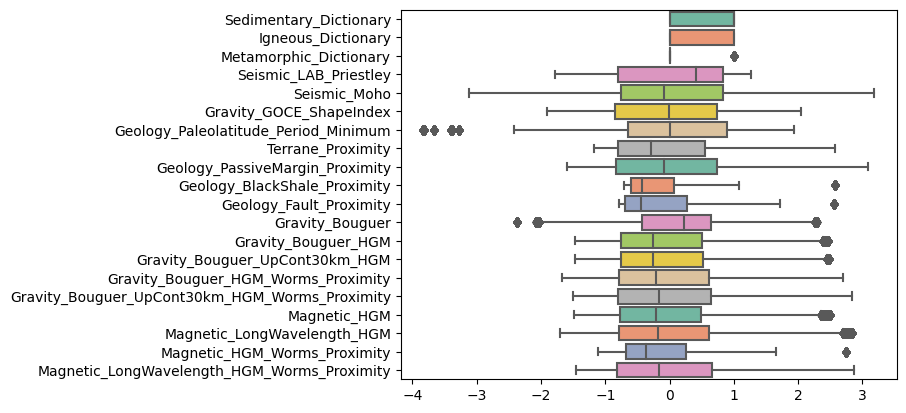

In [17]:
data_filtered_uscan = utils.normalize_df(data_filtered_uscan)
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

Forms the train / test splits

In [83]:
data_filtered_aus["target"] = labels_filtered_aus
data_filtered_aus["H3_Geometry"] = geometry_filtered_aus
data_filtered_aus["Continent_Majority"] = continent_filtered_aus
data_filtered_aus["Latitude_EPSG4326"] = lats_filtered_aus
data_filtered_aus["Training_MVT_Deposit"] = dep_filtered_aus

data_filtered_uscan["target"] = labels_filtered_uscan
data_filtered_uscan["H3_Geometry"] = geometry_filtered_uscan
data_filtered_uscan["Continent_Majority"] = continent_filtered_uscan
data_filtered_uscan["Latitude_EPSG4326"] = lats_filtered_uscan
data_filtered_uscan["Training_MVT_Deposit"] = dep_filtered_uscan

data_filtered = pd.concat((data_filtered_aus, data_filtered_uscan), ignore_index=True)
data_filtered.reset_index(drop=True, inplace=True)

for col in data_filtered.drop(columns=['target','Latitude_EPSG4326','H3_Geometry','Continent_Majority','Training_MVT_Deposit']):
    if data_filtered[col].dtype != "float64" and data_filtered[col].dtype != "bool":
        data_filtered = utils.convert_categorical(data_filtered, col)

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164833 entries, 0 to 5164832
Data columns (total 29 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   Geology_Lithology_Majority                      uint8  
 1   Geology_Lithology_Minority                      uint8  
 2   Geology_Period_Maximum_Majority                 uint8  
 3   Geology_Period_Minimum_Majority                 uint8  
 4   Sedimentary_Dictionary                          bool   
 5   Igneous_Dictionary                              bool   
 6   Metamorphic_Dictionary                          bool   
 7   Seismic_LAB_Priestley                           float64
 8   Seismic_Moho                                    float64
 9   Gravity_GOCE_ShapeIndex                         float64
 10  Geology_Paleolatitude_Period_Minimum            float64
 11  Terrane_Proximity                               float64
 12  Geology_PassiveMargin_Proxim

In [84]:
te_df, tr_df, _ = utils.get_spatial_cross_val_idx(data_filtered, test_set=1, split_col="Training_MVT_Deposit", nbins=72)
tr_df = tr_df.drop(columns=["Training_MVT_Deposit"])
te_df = te_df.drop(columns=["Training_MVT_Deposit"])

# test_set = 1 closest split counts in paper
print(f"Train counts: {tr_df['target'].value_counts()}")
print(f"Test counts: {te_df['target'].value_counts()}")

Train counts: target
False    4301113
True        1528
Name: count, dtype: int64
Test counts: target
False    861693
True        499
Name: count, dtype: int64


In [266]:
gain = 400
hist_gbm_classifier = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_iter=110,              # Number of boosting iterations (equivalent to n_estimators)
    max_depth=7,              # Maximum tree depth
    min_samples_leaf=48,      # Minimum samples required for a leaf node
    max_leaf_nodes=64,        # Maximum number of leaf nodes
    verbose=1,                # Show progress bars
    l2_regularization=0,
    class_weight={0: 1, 1: gain},
    # class_weight="balanced",
    validation_fraction=0.1,
    random_state=1234,
    categorical_features=np.asarray([tr_df[col].dtype != "float64" for col in tr_df.drop(columns=['target','Latitude_EPSG4326','group','H3_Geometry','Continent_Majority'])]).astype(bool)
)

In [267]:
hist_gbm_classifier.fit(tr_df.drop(columns=['target','Latitude_EPSG4326','group','H3_Geometry','Continent_Majority']), tr_df['target'])

Binning 0.743 GB of training data: 1.046 s
Binning 0.083 GB of validation data: 0.060 s
Fitting gradient boosted rounds:
[1/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.32517, val loss: 0.32873, in 0.140s
[2/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.29149, val loss: 0.29802, in 0.130s
[3/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.26638, val loss: 0.27503, in 0.132s
[4/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.24621, val loss: 0.25736, in 0.142s
[5/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.22942, val loss: 0.24281, in 0.146s
[6/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.21487, val loss: 0.22950, in 0.151s
[7/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.20216, val loss: 0.21814, in 0.144s
[8/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.19101, val loss: 0.20823, in 0.145s
[9/110] 1 tree, 64 leaves, max depth = 7, train loss: 0.18121, val loss: 0.19933, in 0.151s
[10/110] 1 tree, 64 leaves, max depth = 7, train lo

HistGradientBoostingClassifier(categorical_features=array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]),
                               class_weight={0: 1, 1: 400}, l2_regularization=0,
                               learning_rate=0.08, max_depth=7, max_iter=110,
                               max_leaf_nodes=64, min_samples_leaf=48,
                               random_state=1234, verbose=1)

In [268]:
y_pred = hist_gbm_classifier.predict_proba(tr_df.drop(columns=['target','Latitude_EPSG4326','group','H3_Geometry','Continent_Majority']))
auc_score = roc_auc_score(tr_df["target"], y_pred[:,1])
print(f"Train AUC score:{auc_score}")

y_pred = hist_gbm_classifier.predict_proba(te_df.drop(columns=['target','Latitude_EPSG4326','group','H3_Geometry','Continent_Majority']))
auc_score = roc_auc_score(te_df['target'], y_pred[:,1])
print(f"Test AUC score:{auc_score}")

all_df = pd.concat([tr_df, te_df])
y_pred = hist_gbm_classifier.predict_proba(all_df.drop(columns=['target','Latitude_EPSG4326','group','H3_Geometry','Continent_Majority']))
auc_score = roc_auc_score(all_df["target"], y_pred[:,1])
print(f"All AUC score:{auc_score}")

Train AUC score:0.9966415492354059
Test AUC score:0.9735277600168791
All AUC score:0.9916394582316796


Produces the GBM prospectivity raster.

In [269]:
# from shapely import wkt
# import rasterio

# all_df["preds"] = y_pred[:,1]

# raster_df = all_df[["H3_Geometry","Continent_Majority","preds"]].copy()

# continents = {
#     # "Oceania": {'left':112.9, 'bottom':-43.6, 'right':153.6, 'top':-9.5},
#     "North America": {'left':-179.8, 'bottom':24.5, 'right':-52.6, 'top':83.15}
# }

# resolution = (0.01, 0.01)

# raster_df["H3_Geometry"] = raster_df["H3_Geometry"].apply(wkt.loads)

# nodata_value = rasterio.open("./data2/GeophysicsGravity_Australia.tif").nodata

# for idx, (continent, bounds) in enumerate(continents.items()):
#     print(f"Rasterizing {continent}")
#     continent_datacube = raster_df[raster_df["Continent_Majority"] == continent]

#     height = int((bounds["top"]-bounds["bottom"]) / resolution[0])
#     width = int((bounds["right"]-bounds["left"]) / resolution[1])

#     tif_tf = rasterio.transform.from_bounds(
#         bounds["left"],
#         bounds["bottom"],
#         bounds["right"],
#         bounds["top"],
#         width,
#         height
#     )

#     tiff_meta = {
#         "driver": 'GTiff',
#         "height": height,
#         "width": width,
#         "count": 1,
#         "dtype": "float64",
#         "crs": rasterio.CRS.from_epsg(4326),
#         "transform": tif_tf,
#         "nodata": nodata_value,
#         "compress": "lzw",
#     }

#     # continent_datacube.rename({
#         # geology
#         # "Geology_Lithology_Majority": "Lithology (major)",
#         # "Geology_Period_Maximum_Majority": "Period (maximum)",
#         # "Geology_Period_Minimum_Majority": "Period (minimum)",
#         # "Geology_Paleolatitude_Period_Maximum": "Paleo-latitude",
#         # "Terrane_Proximity": "Proximity to terrane boundaries",
#         # "Geology_PassiveMargin_Proximity": "Proximity to passive margins",
#         # "Geology_BlackShale_Proximity": "Proximity to black shales",
#         # "Geology_Fault_Proximity": "Proximity to faults",
#         # "Sedimentary_Dictionary": "Sedimentary dictionaries",
#         # "Igneous_Dictionary": "Igneous dictionaries",
#         # "Metamorphic_Dictionary": "Metamorphic dictionaries",
#         # geophysics
#     #     "Seismic_LAB_Priestley": "Depth to Lab",
#     #     "Seismic_Moho": "Depth to Moho",
#     #     "Gravity_GOCE_ShapeIndex": "Satellite Gravity",
#     #     "Gravity_Bouguer": "Gravity Bouguer",
#     #     "Gravity_Bouguer_HGM": "Gravity HGM",
#     #     "Gravity_Bouguer_UpCont30km_HGM": "Gravity upward-continued HGM",
#     #     "Gravity_Bouguer_HGM_Worms_Proximity": "Gravity Worms",
#     #     "Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity": "Gravity upward-continued worms",
#     #     "Magnetic_HGM": "Magnetic HGM",
#     #     "Magnetic_LongWavelength_HGM": "Magnetic long-wavelength HGM",
#     #     "Magnetic_HGM_Worms_Proximity": "Magnetic worms",
#     #     "Magnetic_LongWavelength_HGM_Worms_Proximity": "Magnetic long-wavelength worms"
#     # }, axis=1, inplace=True)
    
#     # utils.visualize_datacube(continent_datacube, tiff_meta)

#     utils.rasterize_datacube(continent_datacube, tiff_meta, './data/maps/', "lawley_gbm_"+continent.lower().replace(" ","-"))